<h3>Sentiment Analysis (Evaluations)</h3>

1. DATA EXPLORATION

2. PRE-TRAINED MODELS: COMPARING PERFORMANCE

In [ ]:
import pandas as pd

In [ ]:
comments=pd.read_excel('comments.xlsx')
comments

In [1]:
#install vaderSentimentlibrary
!pip install vaderSentiment

#import the library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return negative, neutral, positive, compound, overall_sentiment

     -------------------------------------- 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
a=comments.apply(lambda x: sentiment_vader(x['Comments']),axis=1)
a.iloc[46]

In [ ]:

# install textblob
!pip install textblob

# import it
from textblob import TextBlob

#call the classifier
def sentiment_texblob(row):
  
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    subjectivity = classifier.sentiment.subjectivity
    
    return polarity,subjectivity

In [ ]:
b=comments.apply(lambda x: sentiment_texblob(x['Comments']),axis=1)
b

In [ ]:
!pip install happytransformer
from happytransformer import HappyTextClassification
happy_tc=HappyTextClassification(model_type='DISTILBERT',model_name='distilbert-base-uncased-finetuned-sst-2-english',num_labels=2)


In [ ]:
c=comments.apply(lambda x: happy_tc.classify_text(x['Comments']),axis=1)

In [ ]:
c

In [ ]:
!pip install sklearn
!pip install sentence-transformers

In [3]:
import pandas as pd
comments=pd.read_excel('comments.xlsx')

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

n_gram_range = (1, 1)
stop_words = "english"

sentences=comments['Comments'].values.tolist()
# Extract candidate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(sentences)
candidates = count.get_feature_names()

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)
# doc_embedding
comments['Doc_Embed']=comments.apply(lambda x: model.encode([x['Comments']]),axis=1)
comments['Distance']=comments.apply(lambda x:cosine_similarity(x['Doc_Embed'],candidate_embeddings),axis=1)
top_n = 5

comments['Keywords']=comments['Distance'].apply(lambda x: [candidates[index] for index in x.argsort()[0][-top_n:]])

c:\Users\WongQiHuiYve\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
comments['Keywords']

In [11]:

# QUESTION ANSWERING: Very very bad
from transformers import pipeline

# Load sentiment analysis and question answering models
sa_model = pipeline("sentiment-analysis")
qa_model = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')

# Review to analyze

comments['Sentiment']=comments['Comments'].apply(lambda x: sa_model(x)[0]['label'])

# comments['Questions']=['Why was it good?','Why was it bad?','What can be improved?']
comments['Good']=comments['Comments'].apply(lambda x:qa_model(question='What was bad?', context=x)['answer'])
print(comments['Good'])


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


0                                problem-solving skills
1        They remained calm and composed under pressure
2                              critical thinking skills
3                                   managing their time
4                                  communication skills
5     adjusting their approach as needed to overcome...
6     all necessary information was recorded accurately
7     They were able to work independently, demonstr...
8                                    clinical judgement
9                                 complex patient cases
10                       excellent communication skills
11                     lack of commitment to their work
12                            flustered and overwhelmed
13    lack of understanding of the ethical considera...
14                   tension within the healthcare team
15    failing to seek out opportunities to expand th...
16                               delays in patient care
17                              unprofessional b

In [13]:
!pip install wordcloud
!pip install matplotlib
from matplotlib import pyplot as plt

import gensim
from gensim import corpora
from gensim.models import LdaModel

# Define a list of documents to use for topic modeling
documents = comments['Comments'].values.tolist()

# Preprocess the documents by tokenizing and removing stop words
stopwords = set(gensim.parsing.preprocessing.STOPWORDS)
texts = [[word for word in document.lower().split() if word not in stopwords]
         for document in documents]

# Create a dictionary and bag-of-words representation of the documents
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train an LDA model on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=10)

# Print the top words for each topic
for topic in lda_model.print_topics():
    print(topic)

(0, '0.073*"medical" + 0.052*"student" + 0.039*"showed" + 0.027*"excellent" + 0.017*"lack" + 0.017*"work" + 0.017*"able" + 0.016*"conveying" + 0.016*"communication" + 0.015*"skills,"')
(1, '0.040*"student" + 0.040*"medical" + 0.031*"demonstrated" + 0.022*"skills," + 0.022*"excellent" + 0.022*"difficult" + 0.012*"carefully" + 0.012*"problem-solving" + 0.012*"skills" + 0.012*"making"')
(2, '0.030*"patient" + 0.028*"effectively" + 0.022*"able" + 0.022*"work" + 0.022*"healthcare" + 0.022*"causing" + 0.022*"unable" + 0.022*"care." + 0.022*"complex" + 0.013*"frequently"')


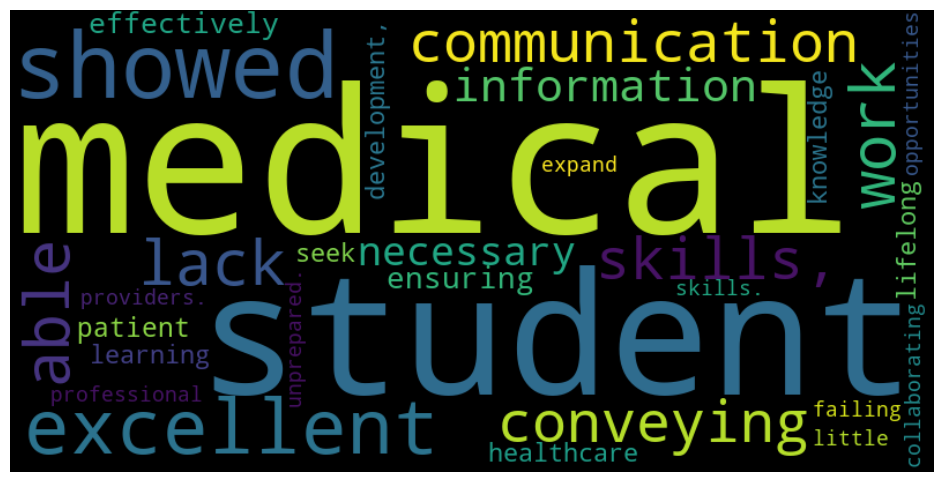

In [14]:
# TOPIC MODELLING: does not look very insightful
# all same topic technically

from wordcloud import WordCloud

# Generate a word cloud for the first topic
topic_words = lda_model.show_topic(0, 30)
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(dict(topic_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# sentiment analysis, topic modelling, QA, keyword extraction/ner

# self trained model, online dataset
# fine tuning an existing model, self labelled dataset
# self trained model, self labelled dataset

# possible insights: if a certain programme has more negative comments, can reconsider the curriculum of the programe
# other options for future consideration: amazon comprehend, google natural language api
# limitation: word cannot be too long